In [1]:
import numpy as np
import qutip as qt
import qinfer as qi
from scipy.sparse import find

C:\Users\chgranad.REDMOND\Source\Repos\conda\devenv\envs\bayesian-acronym\lib\site-packages\IPython\parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
C:\Users\chgranad.REDMOND\Source\Repos\conda\devenv\envs\bayesian-acronym\lib\site-packages\qinfer\parallel.py:52: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  "Could not import IPython parallel. "


In [2]:
import datetime

In [3]:
from toolz import compose

In [4]:
from operator import mul, matmul

In [5]:
from bacronym.groups import Group, eq_ignore_phase
from bacronym.abstract_problems import TraditionalRBProblem, RandomizedBenchmarkingOracle, AcronymOptimization, pgh_like, mean_seq, geommean_seq
from bacronym.plot_utils import plot_rb_results, plot_optimization_results
from bacronym.tex_utils import TeXGenerator

In [6]:
from pathlib import Path

In [7]:
prose = TeXGenerator(Path('..') / 'tex' / 'generated' / 'overrotation-example.tex')

In [8]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['legend.edgecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'
%matplotlib inline

In [9]:
def swap(fn):
    def swapped(*args):
        return fn(*reversed(args))
    return swapped

In [10]:
I, X, Y, Z = qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()
sI, sX, sY, sZ = map(qt.to_super, [I, X, Y, Z])

H = qt.hadamard_transform()
S = qt.phasegate(theta=np.pi / 2)

In [11]:
qt.to_super(S) * qt.to_super(S)

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0.  1.]]

In [12]:
def eq_close_norm(A, B):
    return (A - B).norm('max') <= 1e-8

In [13]:
def eq_ignore_phase_sparse(A, B):
    rows_A, cols_A, vals_A = find(A.data)
    rows_B, cols_B, vals_B = find(B.data)
    
    if not (np.all(rows_A == rows_B) and np.all(cols_A == cols_B)):
        return False
    
    # FIXME: assumes csr.
    comp = vals_A / vals_B
    if not (np.all(np.abs(np.abs(comp) - 1) <= 1e-10)):
        return False
    
    if not np.all(np.abs(np.angle(comp[1:]) - np.angle(comp[0]) <= 1e-10)):
        return False
    
    return True

In [14]:
twirling_group = Group(
    {'H': qt.to_super(H), 'S': qt.to_super(S)},
    qt.to_super(I), eq_close_norm, mul
)

Average generator length per element length. Note that this takes a long time the first time it is run, as the twirling group builds a trie of simplifications that will accelerate future calls.

In [15]:
element_lens = np.arange(2, 51)
n_samples = 1000
generator_lens = np.empty(element_lens.shape + (n_samples, ), dtype=float)
for idx_len, element_len in enumerate(element_lens):
    generator_lens[idx_len] = np.array([
        len(twirling_group.sample_identity_seq(element_len))
        for idx_seq in range(n_samples)
    ])

In [16]:
bins = np.linspace(0, generator_lens.max(), 101)
hist_vs_len = np.empty((len(element_lens), len(bins) - 1))
for idx_element_len in range(len(element_lens)):
    hist_vs_len[idx_element_len, :] = np.histogram(generator_lens[idx_element_len], bins=bins, density=True)[0]

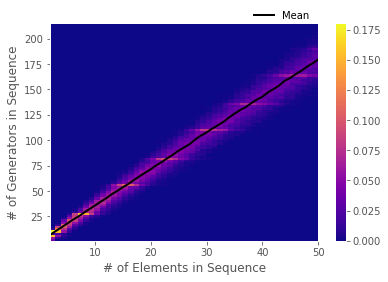

In [17]:
plt.pcolor(element_lens, (bins[1:] + bins[:-1]) / 2, hist_vs_len.T, cmap='plasma')
plt.plot(element_lens, generator_lens.mean(axis=-1), 'k-', lw=2, label='Mean')
plt.xlabel('# of Elements in Sequence')
plt.ylabel('# of Generators in Sequence')
plt.legend(bbox_to_anchor=(1, 1.1), facecolor='none', edgecolor='none')
plt.colorbar()
plt.savefig('../fig/element-vs-generator-len.pdf', bbox_inches='tight')

In [18]:
depol_channel = (sI + sX + sY + sZ) / 4

In [19]:
class OverrotationProblem(TraditionalRBProblem):
    @property
    def n_controlparams(self): return 1
    @property
    def dim_hilbert_space(self): return 2
    @property
    def twirling_group(self): return self._twirling_group
    @property
    def target_gate_name(self): return self._target_gate_name
    @property
    def reference_generators(self): return self._reference_generators    
    
    def __init__(self, twirling_group, target_gate_name='S', reference_depol_strength=0.005):
        super().__init__()
        
        self._twirling_group = twirling_group
        self._target_gate_name = target_gate_name
        
        self._reference_generators = {
            # Pick a 0.05% depol H.
            generator_name:
                (reference_depol_strength * depol_channel) +
                (1 - reference_depol_strength) * sI * twirling_group.matrix_repr((generator_name, ))
            for generator_name in twirling_group.generators
            if generator_name != target_gate_name
        }
        
    def target_gate(self, params):
        θ, = params
        return qt.to_super((-1j * θ * Z).expm())

In [20]:
problem = OverrotationProblem(twirling_group)

In [21]:
θs = np.linspace(0, np.pi, 601)[:, None]
problem = OverrotationProblem(twirling_group)
objective_values = np.array(list(map(problem.objective, θs)))
lambda_ref_agfs = np.array(list(map(compose(qt.average_gate_fidelity, problem.lambda_ref), θs)))

In [22]:
true_rb_parameters = np.array(list(map(problem.true_rb_parameters, θs)))

In [23]:
problem.lambda_ref([0])

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
Qobj data =
[[0.99688073 0.         0.         0.00311927]
 [0.         0.99376145 0.         0.        ]
 [0.         0.         0.99376145 0.        ]
 [0.00311927 0.         0.         0.99688073]]

In [24]:
fig, (left, right) = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

plt.sca(left)
plt.plot(θs, lambda_ref_agfs, label=r'$\operatorname{AGF}(\Lambda_{\mathrm{ref}}(\theta))$')
plt.plot(θs, objective_values, label=r'$♥(\theta)$')
plt.xlabel(r'$\theta$')
plt.legend(ncol=2, bbox_to_anchor=(1, 1.1), edgecolor='none', facecolor='none')
plt.gca().set_yscale('infidelity')

plt.sca(right)
for idx_label, label in enumerate('pAB'):
    plt.plot(θs, true_rb_parameters[:, idx_label], label=f"${label}$")
    plt.legend(ncol=3, bbox_to_anchor=(1, 1.1), edgecolor='none', facecolor='none')
plt.xlabel(r'$\theta$')

plt.savefig('../fig/unitary-overrotation-objective.pdf')

C:\Users\chgranad.REDMOND\Source\Repos\bayesian-acronym\src\bacronym\plot_utils.py:43: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - a)
C:\Users\chgranad.REDMOND\Source\Repos\bayesian-acronym\src\bacronym\plot_utils.py:28: RuntimeWarning: divide by zero encountered in log10
  log_infid = np.log10(1 - x)


Let's find the smallest Lipshitz continuity criterion.

In [25]:
def diff_by(arr, n=1):
    return arr[n:] - arr[:-n]

In [26]:
def lipschitz(xs, ys):
    worst = -np.inf
    for n_steps in range(1, xs.shape[0] - 1):
        dxs = diff_by(xs, n_steps)
        dys = diff_by(ys, n_steps)
        this_worst = np.max(dys / dxs)
        worst = this_worst if worst < this_worst else worst
    return worst

In [27]:
prose.write_item('unitaryOverrotationObjectiveLipschitz', lipschitz(θs, objective_values), '0.3')
prose.write_item('unitaryOverrotationRefAGFLipschitz', lipschitz(θs, lambda_ref_agfs), '0.3')

\unitaryOverrotationObjectiveLipschitz ≔ 1.48
\unitaryOverrotationRefAGFLipschitz ≔ 1.13


Now let's simulate.

In [28]:
opt = AcronymOptimization(
    OverrotationProblem(twirling_group),
    qi.ProductDistribution(
        qi.UniformDistribution([0, 1]),
        qi.UniformDistribution([0, 1]),
        qi.NormalDistribution(0.5, 0.05 ** 2)
    )
)

In [29]:
est_F, results = opt.iterate([0.04], n_shots_per_len=20, required_accuracy=0.01)

C:\Users\chgranad.REDMOND\Source\Repos\conda\devenv\envs\bayesian-acronym\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\chgranad.REDMOND\Source\Repos\conda\devenv\envs\bayesian-acronym\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\chgranad.REDMOND\Source\Repos\conda\devenv\envs\bayesian-acronym\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. U

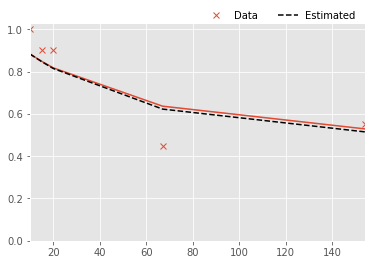

In [30]:
plot_rb_results(results)
plt.savefig('../fig/overrotation-synthetic-rb-data.pdf', bbox_inches='tight')

	Diffusing by [0.01 0.01 0.01] to get from [0.04] to [0.05].


C:\Users\chgranad.REDMOND\Source\Repos\conda\devenv\envs\bayesian-acronym\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\chgranad.REDMOND\Source\Repos\conda\devenv\envs\bayesian-acronym\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


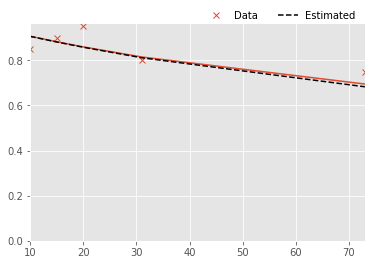

In [31]:
n_shots_per_len = 5
plot_rb_results(opt.iterate([0.05], n_shots_per_len=20, required_accuracy=0.01)[1])

	Diffusing by [0.02 0.02 0.02] to get from [0.05] to [0.07].


C:\Users\chgranad.REDMOND\Source\Repos\conda\devenv\envs\bayesian-acronym\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\chgranad.REDMOND\Source\Repos\conda\devenv\envs\bayesian-acronym\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


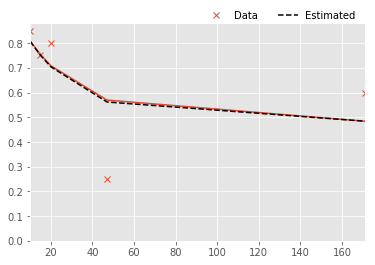

In [32]:
n_shots_per_len = 5
plot_rb_results(opt.iterate([0.07], n_shots_per_len=20, required_accuracy=0.01)[1])

	Diffusing by [0.09 0.09 0.09] to get from [0.07] to [-0.02].


C:\Users\chgranad.REDMOND\Source\Repos\conda\devenv\envs\bayesian-acronym\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\chgranad.REDMOND\Source\Repos\conda\devenv\envs\bayesian-acronym\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


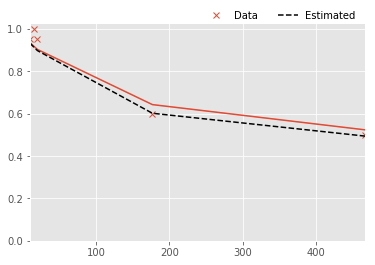

In [33]:
n_shots_per_len = 5
plot_rb_results(opt.iterate([-0.02], n_shots_per_len=20, required_accuracy=0.01)[1])

Now we perturb the particles slightly and update to increment $\theta \to \theta + 0.01$. Based on the calculations above, we TODO.

In [34]:
twirling_group_with_X = Group(
    {'H': qt.to_super(H), 'S': qt.to_super(S), 'X': qt.to_super(X)},
    qt.to_super(I), eq_close_norm,
    # Make it such that elements follow time ordering when read, but matrix mul order when represented.
    swap(mul)
)

In [35]:
problem_with_X = OverrotationProblem(
    twirling_group_with_X,
    reference_depol_strength=0.005
)

In [36]:
lipschitz(θs, np.array(list(map(compose(qt.average_gate_fidelity, problem_with_X.lambda_ref), θs))))

0.4809608493631079

In [37]:
def random_scaling(heuristic):
    def heuristic_class(updater):
        underlying_heuristic = heuristic(updater)
        def randomized_heuristic():
            underlying = underlying_heuristic()
            scale = np.random.random()
            rescaled = int(underlying * scale)
            return rescaled
        return randomized_heuristic 
    return heuristic_class

In [38]:
opt = AcronymOptimization(
    OverrotationProblem(twirling_group),
    qi.ProductDistribution(
        qi.UniformDistribution([0, 1]),
        # Assume a tight initial prior around A = B = 0.5.
        qi.UniformDistribution([0, 1]),
        qi.NormalDistribution(0.5, 0.05 ** 2)
    ),
    
    # Assume that B varies much much less than do p and A.
    continuity=[2, 2, 0.02]
)

In [39]:
# Warm up then optimize.
opt.iterate([0.35], n_shots_per_len=20, required_accuracy=0.01, est_fidelity_options={'max_sequences': 2000})
print('Optimizing:')
results = opt.optimize(
    [0.35],
    n_shots_per_len=1,
    max_iterations=500,
    
    gain_scale=0.1,
    gain_exp=0.602*0,
    step_scale=5e-2,
    step_exp=0,
    
    
    verbose=True,
    required_accuracy=0.005,
    
    min_update=1e-4,
    
    est_fidelity_options={
        'n_warmup_lengths': 40,
        'warmup_sequence_length_step': 1,
        'warmup_sequence_length_step': 1,
        'max_sequences': 500,
        'verbose': True,
        'cheat' : False,
        
        'min_sequence_length': 3,
        
        'n_particles': 1000 * 2 ** 8,
        'updater_options': {
            'resample_thresh': 2.0 ** -8
        },
        'heuristic_class': pgh_like
    }
)
results

Optimizing:
Control parameters still at [0.35], reusing existing updater.
		Max sequences reached.
	F̂([0.35]) = 0.718073784403086 ± 0.21764847151897848
	(p̂, Â, B̂) = [0.43614757 0.68047013 0.50882198]
	𝔼[m] = 5.568, 𝕍[m] = 69.48937600000001
	True fidelity at [0.35]: 0.644859301513229
	Testing at [0.3].
	Diffusing by [0.1   0.1   0.001] to get from [0.35] to [0.3].
		Max sequences reached.
	F̂([0.3]) = 0.8130838822766975 ± 0.11994757286678107
	(p̂, Â, B̂) = [0.62616776 0.81222763 0.50760418]
	𝔼[m] = 5.684, 𝕍[m] = 67.61214400000001
	True fidelity at [0.3]: 0.7092248368386175
	Estimated gradient: [-1.90020196].
	Maximum update exceeded, rescaling to 0.1.
Control parameters still at [0.3], reusing existing updater.
		Max sequences reached.
	F̂([0.3]) = 0.8036869724508707 ± 0.11670958063968573
	(p̂, Â, B̂) = [0.60737394 0.80515467 0.51018874]
	𝔼[m] = 5.676, 𝕍[m] = 68.635024
	True fidelity at [0.3]: 0.7092248368386175
Completed iteration 0, setting controls to [0.3].
	Testing at [0.35].

OptimizationResults(control_params=array([-0.01886265]), est_fidelity=0.9967731715730688, stopping_reason='Target fidelity achieved.', n_sequences_used=7074, history=[OptimizationHistoryPoint(control_params=array([0.35]), est_fidelity=0.718073784403086, cred_fidelity=(0.5000653043588816, 0.9961623334344574), n_sequences_used=500, sequence_lengths=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49,  3,  4,  3,  3,  3,  3,  3,  3,  3,  5,  4,
        3,  3,  3,  3,  9,  4,  3,  3, 11,  7,  5,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3, 16,  3,  3,  3,  3,  3,  3,  3,  3,  5,  5,  3,  3,  3,
        8,  3,  3,  3, 27,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  5,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  5,  3,  3,  3,  3,  3,  3,  3,  5,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  6,
        3,  3,  3,  3,  3,  3,  3,  5,  3,  3,  3,  3,  3,  3,  3,  3, 10,
        3,  3,  3,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  7,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  6,  3,  3,  3,  3,  3,  6, 16,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3, 59,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4,  3,  6,  8,  3,  3,  3,  3,  3,  3,  3,  6,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  8,  3,  7,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  9,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3, 15,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  5,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  7,  5,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,
        3,  3,  4,  3,  3,  3,  3,  6,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3]), true_fidelity=0.644859301513229), OptimizationHistoryPoint(control_params=array([0.3]), est_fidelity=0.8130838822766975, cred_fidelity=(0.500533974918813, 0.9999961588257305), n_sequences_used=1000, sequence_lengths=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49,  3,  3,  3,  3,  3,  3,  4,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3, 31,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 24,  3,  3,  3,  3,  4,  5,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  9,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3, 11,  3,  3,  3,  3,  3,  3,  3, 32,  4,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4, 12,  3,  5,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  5,  3,  3,  3,  3,  3,  3,  3,  3,  3, 15,  3,  3,  8,  4,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  3,  3,  5,  3,  3,  3,  3,
       15,  3,  3,  3,  3,  3,  3,  6,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  3,  5,  3,  3,  3,  3,  5,
        3,  3,  3,  3, 

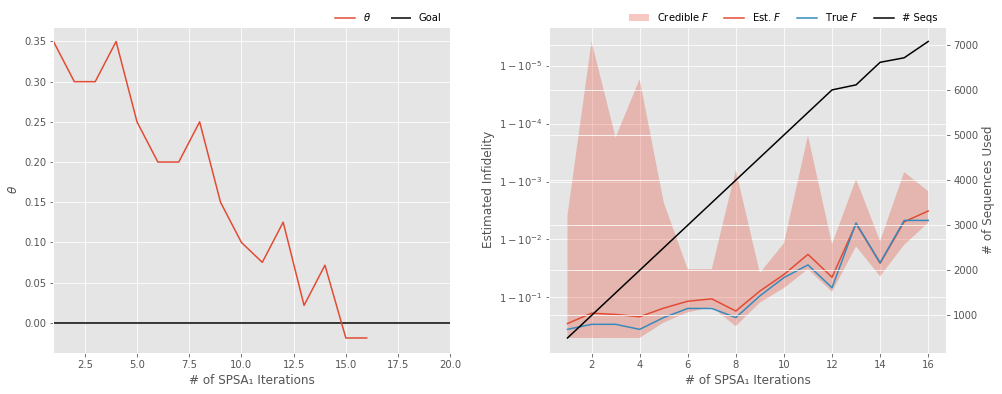

In [40]:
fig, (left, right) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plot_optimization_results(results, axes=right)

left.plot(
    1 + np.arange(len(results.history)),
    [history_point.control_params for history_point in results.history],
    label=r'$\theta$'
)
plt.sca(left)
xlim = [1,20]
plt.hlines(0, *xlim, label='Goal')
plt.xlim(*xlim)
left.set_ylabel(r'$\theta$')
left.set_xlabel('# of SPSA₁ Iterations')
left.legend(ncol=2, bbox_to_anchor=(1, 1.075))

fig.subplots_adjust(wspace=0.25)

plt.savefig('../fig/overrotation-bacronym-perf_alpha.pdf', bbox_inches='tight')